# Question 1

In [4]:
# Linear Optimization – Vertex Evaluation Approach (Parts a, b, c)
# Constraints:
#   400*r + 2000*t <= budget
#   t >= 3*r
#   r, t >= 0
# Vertices considered:
#   (0,0), (0, budget/2000), intersection of budget line with t=3r
# Note: r-axis intercept is infeasible except r=0 because t >= 3r.

r_orig, t_orig = 3.91, 11.72
exp_orig = 9960.94

def vertices_for_budget(budget):
    v1 = (0.0, 0.0)
    v2 = (0.0, budget / 2000.0)      # when r=0 -> 2000*t = budget
    r3 = budget / 6400.0             # from 400*r + 2000*(3r) = budget -> 6400*r = budget
    t3 = 3.0 * r3
    v3 = (r3, t3)
    return [v1, v2, v3]

def exposure(r, t, radio_coeff, tv_coeff):
    return radio_coeff * r + tv_coeff * t

def solve_case(budget, radio_coeff, tv_coeff):
    verts = vertices_for_budget(budget)
    best = None
    for r, t in verts:
        exp = exposure(r, t, radio_coeff, tv_coeff)
        if (best is None) or (exp > best[2]):
            best = (r, t, exp)
    return best  # (r, t, exposure)

def changed_from_original(r_new, t_new, tol=1e-2):
    return not (round(r_new, 2) == round(r_orig, 2) and round(t_new, 2) == round(t_orig, 2))

# ---------- PART A: TV exposure = 825 (budget = 25000) ----------
budget_A = 25000.0
radio_coeff_A = 300.0
tv_coeff_A = 825.0
rA, tA, expA = solve_case(budget_A, radio_coeff_A, tv_coeff_A)

# ---------- PART B: Radio exposure = 200 (budget = 25000) ----------
budget_B = 25000.0
radio_coeff_B = 200.0
tv_coeff_B = 750.0
rB, tB, expB = solve_case(budget_B, radio_coeff_B, tv_coeff_B)

# ---------- PART C: Budget increased by $3,000 -> budget = 28000 ----------
budget_C = 25000.0 + 3000.0
radio_coeff_C = 300.0
tv_coeff_C = 750.0
rC, tC, expC = solve_case(budget_C, radio_coeff_C, tv_coeff_C)

# ---------- Print Results ----------
def print_result(part_label, r, t, exp, radio_coeff, tv_coeff, budget):
    print(f"=== Part {part_label} ===")
    print(f"Parameters: budget = ${budget:.2f}, radio_exposure = {radio_coeff}, tv_exposure = {tv_coeff}")
    print(f"Optimal allocation: Radio = {r:.2f} minutes, TV = {t:.2f} minutes")
    print(f"Maximum exposure = {exp:.2f}")
    print(f"Allotted times {'have' if changed_from_original(r, t) else 'have not'} changed from the original solution (Radio=3.91, TV=11.72).")
    print()

print_result("A (TV exposure = 825)", rA, tA, expA, radio_coeff_A, tv_coeff_A, budget_A)
print_result("B (Radio exposure = 200)", rB, tB, expB, radio_coeff_B, tv_coeff_B, budget_B)
print_result("C (Budget +$3000)", rC, tC, expC, radio_coeff_C, tv_coeff_C, budget_C)

# If you want the script to also show the evaluated vertices for each case, uncomment below:
# for label, (budget, rc, tc) in [("A", (budget_A, radio_coeff_A, tv_coeff_A)),
#                                ("B", (budget_B, radio_coeff_B, tv_coeff_B)),
#                                ("C", (budget_C, radio_coeff_C, tv_coeff_C))]:
#     print(f"Vertices for case {label}:")
#     for v in vertices_for_budget(budget):
#         print("  r={:.6f}, t={:.6f}, exposure={:.6f}".format(v[0], v[1], exposure(v[0], v[1], rc, tc)))
#     print()


print("All are new")

=== Part A (TV exposure = 825) ===
Parameters: budget = $25000.00, radio_exposure = 300.0, tv_exposure = 825.0
Optimal allocation: Radio = 3.91 minutes, TV = 11.72 minutes
Maximum exposure = 10839.84
Allotted times have not changed from the original solution (Radio=3.91, TV=11.72).

=== Part B (Radio exposure = 200) ===
Parameters: budget = $25000.00, radio_exposure = 200.0, tv_exposure = 750.0
Optimal allocation: Radio = 3.91 minutes, TV = 11.72 minutes
Maximum exposure = 9570.31
Allotted times have not changed from the original solution (Radio=3.91, TV=11.72).

=== Part C (Budget +$3000) ===
Parameters: budget = $28000.00, radio_exposure = 300.0, tv_exposure = 750.0
Optimal allocation: Radio = 4.38 minutes, TV = 13.12 minutes
Maximum exposure = 11156.25
Allotted times have changed from the original solution (Radio=3.91, TV=11.72).

All are new


# Question 2

In [7]:
"""
LP solver + simple sensitivity helper for a 2-product, m-resource problem.

Example: Valencia Products with two models (LaserStop, SpeedBuster).
You can change the profit coefficients, the resource usage matrix, or RHS
and re-run scenarios programmatically.

Requires: pulp (pip install pulp)
Optional (for duals/reduced costs): GLPK or COIN-OR installed and available to pulp.
"""

from pprint import pprint
import pulp


def solve_lp(prod_names, profit, usage, resources, solver=None, msg=False):
    """
    Build and solve the LP:
      maximize sum(profit[i] * x_i)
      subject to for each resource j: sum(usage[i][j] * x_i) <= resources[j]
      x_i >= 0

    Arguments:
      prod_names: list of product names (length n)
      profit: dict mapping product -> profit coefficient
      usage: dict mapping product -> dict mapping resource -> usage per unit
             e.g. usage['LaserStop']['A'] = units of A needed per LaserStop
      resources: dict mapping resource -> available units (RHS)
      solver: pulp solver instance (optional). If None, pulp default is used.
      msg: show solver messages (bool)
    Returns:
      dict with: 'prob', 'vars' (dict product->value), 'objective', 'duals' (if available),
                 'reduced_costs' (if available)
    """

    # --- Build problem ---
    prob = pulp.LpProblem("Production", pulp.LpMaximize)

    # decision variables
    x = {p: pulp.LpVariable(f"x_{p}", lowBound=0, cat="Continuous") for p in prod_names}

    # objective
    prob += pulp.lpSum([profit[p] * x[p] for p in prod_names]), "Total_Profit"

    # constraints
    resource_constraints = {}
    for r in resources:
        resource_constraints[r] = prob.addConstraint(
            pulp.lpSum([usage[p][r] * x[p] for p in prod_names]) <= resources[r],
            name=f"Res_{r}"
        )

    # solve
    if solver is None:
        prob.solve(pulp.PULP_CBC_CMD(msg=msg))
    else:
        prob.solve(solver)

    # collect primal solution
    var_values = {p: pulp.value(x[p]) for p in prod_names}
    objective_value = pulp.value(prob.objective)

    # try to extract duals (shadow prices) and reduced costs (variable.dj)
    duals = {}
    reduced_costs = {}
    # Note: availability of .pi and .dj depends on the solver and pulp version.
    try:
        for cname, constr in prob.constraints.items():
            # .pi is commonly populated when solver supports duals
            duals[cname] = getattr(constr, "pi", None)
    except Exception:
        duals = None

    try:
        for p in prod_names:
            reduced_costs[p] = getattr(x[p], "dj", None)
    except Exception:
        reduced_costs = None

    result = {
        "prob": prob,
        "vars": var_values,
        "objective": objective_value,
        "duals": duals,
        "reduced_costs": reduced_costs,
        "constraints": resources
    }
    return result


def scenario_change_objective(base_problem, prod_to_change, new_profit):
    """Given base_problem input data, change objective coefficient for a product and resolve."""
    prod_names = base_problem["prod_names"]
    profit = base_problem["profit"].copy()
    profit[prod_to_change] = new_profit
    usage = base_problem["usage"]
    resources = base_problem["resources"]
    print(f"\n--- Re-solving with {prod_to_change} profit changed to {new_profit} ---")
    res = solve_lp(prod_names, profit, usage, resources)
    pprint(res["vars"])
    print("Objective:", res["objective"])
    if res["duals"]:
        print("Duals (shadow prices):")
        pprint(res["duals"])
    if res["reduced_costs"]:
        print("Reduced costs:")
        pprint(res["reduced_costs"])
    return res


def scenario_change_resource(base_problem, resource_to_change, new_rhs):
    """Change RHS for a resource and resolve."""
    prod_names = base_problem["prod_names"]
    profit = base_problem["profit"]
    usage = base_problem["usage"]
    resources = base_problem["resources"].copy()
    resources[resource_to_change] = new_rhs
    print(f"\n--- Re-solving with resource {resource_to_change} RHS changed to {new_rhs} ---")
    res = solve_lp(prod_names, profit, usage, resources)
    pprint(res["vars"])
    print("Objective:", res["objective"])
    if res["duals"]:
        print("Duals (shadow prices):")
        pprint(res["duals"])
    if res["reduced_costs"]:
        print("Reduced costs:")
        pprint(res["reduced_costs"])
    return res


# -----------------------
# Example usage (fill the data below)
# -----------------------
if __name__ == "__main__":
    # Product names
    products = ["LaserStop", "SpeedBuster"]

    # Profit per unit (the objective coefficients)
    # Use your problem's coefficients; for Valencia the report showed 124 and 138 originally:
    profit_coeffs = {"LaserStop": 124.0, "SpeedBuster": 138.0}

    # Resource usage matrix:
    # usage[product][resource] = units of resource required per unit product
    # You should replace these with the true coefficients from your problem statement.
    # If unknown, provide estimates or fill them in.
    #
    # Example placeholders (you can change these before running):
    # For demonstration I put symbolic usage fields; replace with actual numbers.
    usage_matrix = {
        "LaserStop": {"A": 10.0, "B": 5.0},   # <-- replace with real per-unit usage for LaserStop
        "SpeedBuster": {"A": 12.204, "B": 7.93}  # inferred approximate usage for SpeedBuster from given report
    }

    # Resource availabilities (RHS)
    resources_rhs = {"A": 4100.0, "B": 3600.0}

    # Pack base problem
    base = {
        "prod_names": products,
        "profit": profit_coeffs,
        "usage": usage_matrix,
        "resources": resources_rhs
    }

    print("=== Base problem solve ===")
    solution = solve_lp(products, profit_coeffs, usage_matrix, resources_rhs)
    print("Production plan (units):")
    pprint(solution["vars"])
    print("Total profit (objective):", solution["objective"])
    print("\nDuals (shadow prices) and reduced costs (if solver supports them):")
    pprint(solution["duals"])
    pprint(solution["reduced_costs"])

    # ------------------------
    # Examples of sensitivity experiments (you can run similar to a-e)
    # ------------------------

    # (b) Decrease SpeedBuster profit to $134 (from 138)
    scenario_change_objective(base, "SpeedBuster", 134.0)

    # (c) Increase LaserStop profit to $222 (from 124)
    scenario_change_objective(base, "LaserStop", 222.0)

    # (d) Increase component A availability by 1600 (4100 -> 5700)
    new_rhs_A = resources_rhs["A"] + 1600.0
    scenario_change_resource(base, "A", new_rhs_A)

    # (e) Decrease component B availability by 600 (3600 -> 3000)
    new_rhs_B = resources_rhs["B"] - 600.0
    scenario_change_resource(base, "B", new_rhs_B)


=== Base problem solve ===
Production plan (units):
{'LaserStop': 410.0, 'SpeedBuster': 0.0}
Total profit (objective): 50840.0

Duals (shadow prices) and reduced costs (if solver supports them):
{'Res_A': 12.4, 'Res_B': -0.0}
{'LaserStop': -0.0, 'SpeedBuster': -13.3296}

--- Re-solving with SpeedBuster profit changed to 134.0 ---
{'LaserStop': 410.0, 'SpeedBuster': 0.0}
Objective: 50840.0
Duals (shadow prices):
{'Res_A': 12.4, 'Res_B': -0.0}
Reduced costs:
{'LaserStop': -0.0, 'SpeedBuster': -17.3296}

--- Re-solving with LaserStop profit changed to 222.0 ---
{'LaserStop': 410.0, 'SpeedBuster': 0.0}
Objective: 91020.0
Duals (shadow prices):
{'Res_A': 22.2, 'Res_B': -0.0}
Reduced costs:
{'LaserStop': -0.0, 'SpeedBuster': -132.9288}

--- Re-solving with resource A RHS changed to 5700.0 ---
{'LaserStop': 570.0, 'SpeedBuster': 0.0}
Objective: 70680.0
Duals (shadow prices):
{'Res_A': 12.4, 'Res_B': -0.0}
Reduced costs:
{'LaserStop': -0.0, 'SpeedBuster': -13.3296}

--- Re-solving with resourc

# Quexstion 3

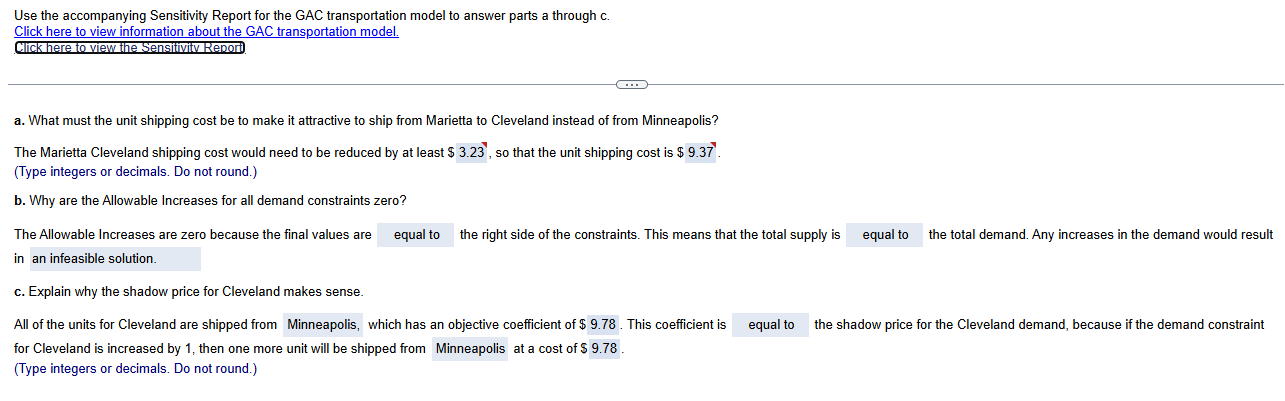


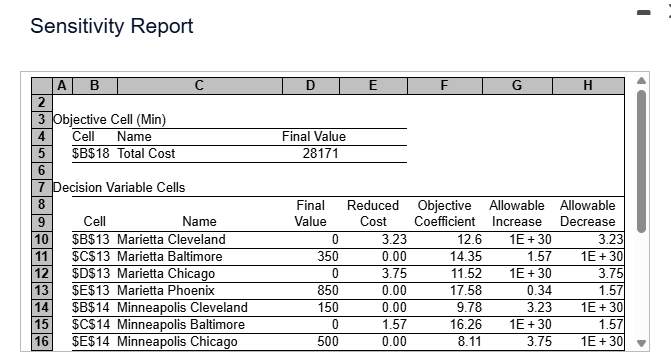

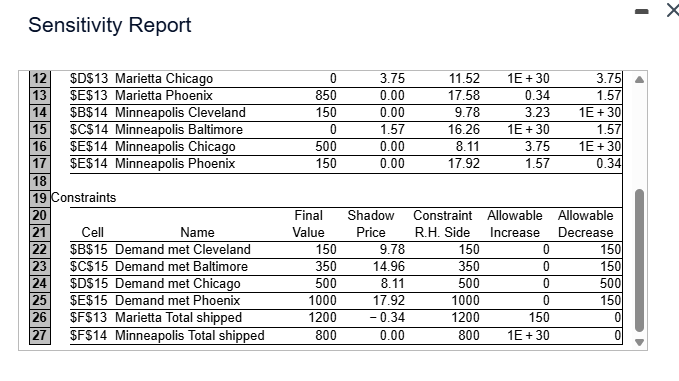

# Question 4

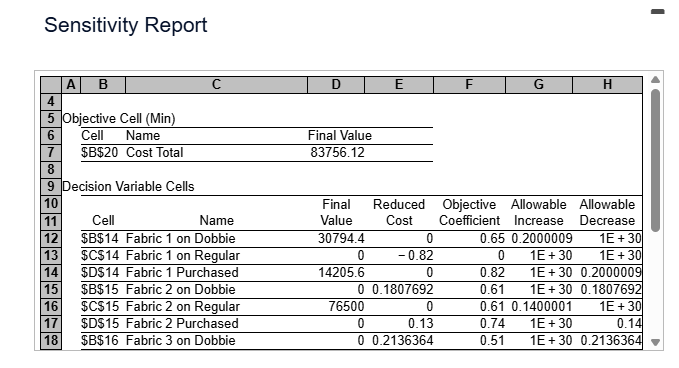

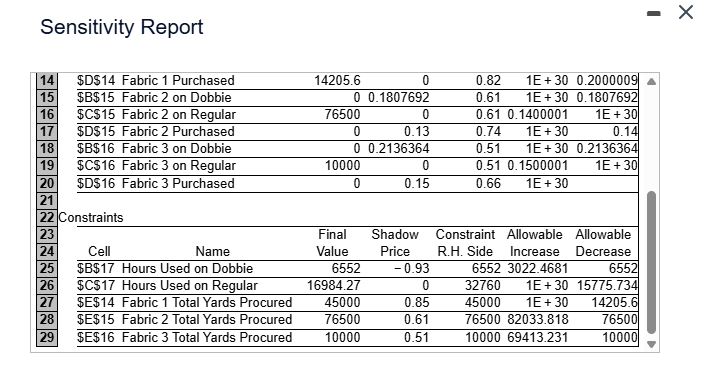

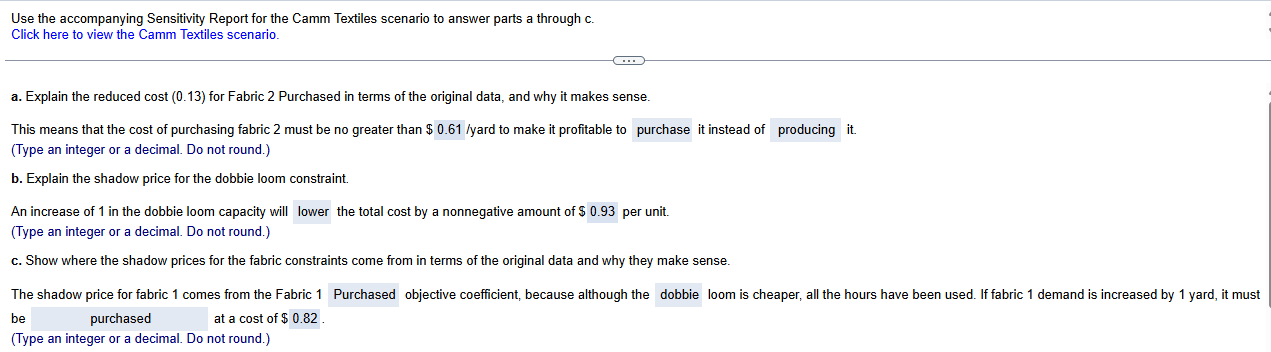

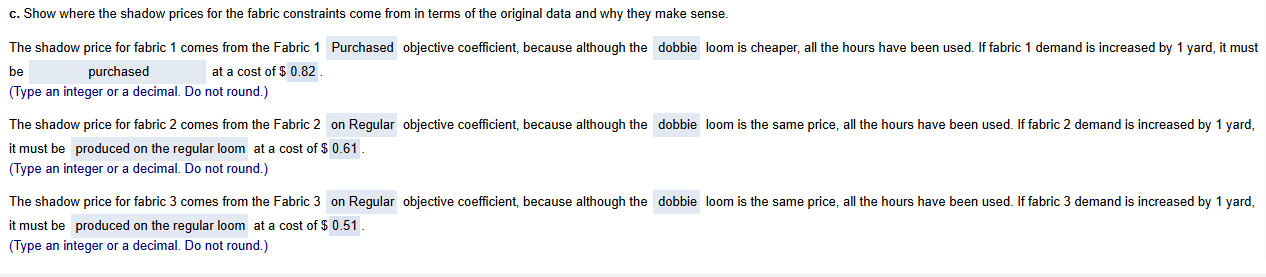

# Question 5

In [1]:
# malloy_milling_solver.py
# Solve the Malloy Milling LP by enumerating corner points (no external LP package required).
# Paste and run in Python 3.7+ or in a Jupyter notebook.

import itertools

# Problem data
c_R = 800.0   # profit per ton regular (R)
c_S = 1600.0  # profit per ton super (S)

# Constraints:
# 1) R + S >= T  (total production)  -- T = 700 for original problem
# 2) R/5 + S/3 <= 168  -> 3R + 5S <= 2520  (time)
# 3) R >= 400
# 4) S >= 200

def feasible(R, S, rhs_total=700.0, tol=1e-8):
    if R + S + tol < rhs_total:   # must be >= rhs_total
        return False
    if 3*R + 5*S - 2520.0 > tol:  # must be <= 2520
        return False
    if R + tol < 400.0:
        return False
    if S + tol < 200.0:
        return False
    return True

# Equality-line identifiers:
# A: R = 400
# B: S = 200
# C: R + S = T
# D: 3R + 5S = 2520
def intersect(line1, line2, T=700.0):
    if line1 == line2:
        return None
    lines = {line1, line2}
    if lines == {'A','B'}:
        return (400.0, 200.0)
    if lines == {'A','C'}:
        R = 400.0
        S = T - R
        return (R, S)
    if lines == {'A','D'}:
        R = 400.0
        S = (2520.0 - 3.0*R) / 5.0
        return (R, S)
    if lines == {'B','C'}:
        S = 200.0
        R = T - S
        return (R, S)
    if lines == {'B','D'}:
        S = 200.0
        R = (2520.0 - 5.0*S) / 3.0
        return (R, S)
    if lines == {'C','D'}:
        R = (5.0*T - 2520.0) / 2.0
        S = T - R
        return (R, S)
    return None

lines = ['A','B','C','D']

def all_candidate_points(T=700.0):
    pts = set()
    for l1, l2 in itertools.combinations(lines, 2):
        p = intersect(l1, l2, T=T)
        if p is not None:
            R, S = p
            pts.add((round(R,10), round(S,10)))
    # include obvious bound corners
    pts.add((400.0, 200.0))
    pts.add((400.0, max(200.0, T - 400.0)))
    pts.add((max(400.0, T - 200.0), 200.0))
    return sorted(list(pts))

def evaluate_candidates(T=700.0, cR=c_R, cS=c_S):
    pts = all_candidate_points(T)
    results = []
    for R, S in pts:
        if feasible(R, S, rhs_total=T):
            obj = cR*R + cS*S
            results.append((R, S, obj))
    # sort by objective descending
    results.sort(key=lambda x: x[2], reverse=True)
    return results

def solve_opt(T=700.0, cR=c_R, cS=c_S):
    results = evaluate_candidates(T=T, cR=cR, cS=cS)
    if not results:
        return None
    return results[0]  # best (R,S,Profit)

if __name__ == "__main__":
    T0 = 700.0
    best = solve_opt(T=T0, cR=c_R, cS=c_S)
    if best:
        R0, S0, P0 = best
        print(f"Original problem (T={T0}): Optimal R={R0:.6f}, S={S0:.6f}, Profit=${P0:,.2f}")
    else:
        print("No feasible solution found for original problem.")

    # Numerical shadow-price estimate for R+S >= T (by +/-1)
    R_up = solve_opt(T=T0+1.0, cR=c_R, cS=c_S)
    R_dn = solve_opt(T=T0-1.0, cR=c_R, cS=c_S)
    if R_up:
        _, _, P_up = R_up
    else:
        P_up = None
    if R_dn:
        _, _, P_dn = R_dn
    else:
        P_dn = None

    print("\nSensitivity (numerical finite-difference):")
    print(f"Profit at T={T0-1:.0f}: ${P_dn:,.2f}" if P_dn is not None else f"T={T0-1:.0f}: infeasible")
    print(f"Profit at T={T0:.0f}: ${P0:,.2f}" if P0 is not None else f"T={T0:.0f}: infeasible")
    print(f"Profit at T={T0+1:.0f}: ${P_up:,.2f}" if P_up is not None else f"T={T0+1:.0f}: infeasible")
    if P_up is not None and P0 is not None:
        shadow_up = P_up - P0
        print(f"Estimated shadow price for increasing T by 1: ${shadow_up:.2f} per ton (increase)")
    if P0 is not None and P_dn is not None:
        shadow_dn = P0 - P_dn
        print(f"Estimated shadow price for decreasing T by 1: ${shadow_dn:.2f} per ton (decrease)")

    # Effect of increasing c_R to $900
    new_cR = 900.0
    best_new = solve_opt(T=T0, cR=new_cR, cS=c_S)
    if best_new:
        R_new, S_new, P_new = best_new
        print("\nWith c_R = $900 (and c_S = $1600):")
        print(f"Optimal R={R_new:.6f}, S={S_new:.6f}, Profit=${P_new:,.2f}")
    else:
        print("No feasible solution when c_R increased (unexpected).")

    # Print all feasible candidate corners for inspection
    print("\nFeasible candidate corners (R, S, Profit) sorted by profit:")
    for R, S, obj in evaluate_candidates(T=T0, cR=c_R, cS=c_S):
        print(f"  R={R:.6f}, S={S:.6f}, Profit=${obj:,.2f}")


Original problem (T=700.0): Optimal R=490.000000, S=210.000000, Profit=$728,000.00

Sensitivity (numerical finite-difference):
Profit at T=699: $728,400.00
Profit at T=700: $728,000.00
Profit at T=701: $727,600.00
Estimated shadow price for increasing T by 1: $-400.00 per ton (increase)
Estimated shadow price for decreasing T by 1: $-400.00 per ton (decrease)

With c_R = $900 (and c_S = $1600):
Optimal R=490.000000, S=210.000000, Profit=$777,000.00

Feasible candidate corners (R, S, Profit) sorted by profit:
  R=490.000000, S=210.000000, Profit=$728,000.00
  R=506.666667, S=200.000000, Profit=$725,333.33
  R=500.000000, S=200.000000, Profit=$720,000.00


In [2]:
# malloy_partA_partB.py
# Evaluate two scenarios for the Malloy Milling LP:
#  - Part B: increase regular grind price c_R from $800 -> $900
#  - Part A: decrease super grind price c_S from $1600 -> $1200
# The script enumerates corner points, checks feasibility, finds optimal corner,
# and determines whether the solution and/or profit change (mapping to options A/B/C).

import itertools
from math import isclose

# Base coefficients
cR_base = 800.0
cS_base = 1600.0

# Constraints and RHS
T0 = 700.0  # R + S >= T0
TIME_MAX = 2520.0  # 3R + 5S <= 2520
R_min = 400.0
S_min = 200.0
EPS = 1e-8

def feasible(R, S, T=T0):
    if R + S + EPS < T:   # must be >= T
        return False
    if 3*R + 5*S - TIME_MAX > EPS:  # must be <= TIME_MAX
        return False
    if R + EPS < R_min:
        return False
    if S + EPS < S_min:
        return False
    return True

# Equality-line identifiers:
# A: R = R_min
# B: S = S_min
# C: R + S = T
# D: 3R + 5S = TIME_MAX
def intersect(line1, line2, T=T0):
    if line1 == line2:
        return None
    lines = {line1, line2}
    if lines == {'A','B'}:
        return (R_min, S_min)
    if lines == {'A','C'}:
        R = R_min
        S = T - R
        return (R, S)
    if lines == {'A','D'}:
        R = R_min
        S = (TIME_MAX - 3.0*R) / 5.0
        return (R, S)
    if lines == {'B','C'}:
        S = S_min
        R = T - S
        return (R, S)
    if lines == {'B','D'}:
        S = S_min
        R = (TIME_MAX - 5.0*S) / 3.0
        return (R, S)
    if lines == {'C','D'}:
        R = (5.0*T - TIME_MAX) / 2.0
        S = T - R
        return (R, S)
    return None

lines = ['A','B','C','D']

def all_candidate_points(T=T0):
    pts = set()
    for l1, l2 in itertools.combinations(lines, 2):
        p = intersect(l1, l2, T=T)
        if p is not None:
            R, S = p
            # keep as float
            pts.add((float(R), float(S)))
    # also include bound-related obvious points
    pts.add((R_min, S_min))
    pts.add((R_min, max(S_min, T - R_min)))
    pts.add((max(R_min, T - S_min), S_min))
    return sorted(list(pts))

def evaluate(T=T0, cR=cR_base, cS=cS_base):
    candidates = all_candidate_points(T=T)
    feasible_pts = []
    for R, S in candidates:
        if feasible(R, S, T=T):
            profit = cR*R + cS*S
            feasible_pts.append((R, S, profit))
    # sort descending by profit
    feasible_pts.sort(key=lambda x: x[2], reverse=True)
    return feasible_pts

def solve_and_classify(cR_new, cS_new, label):
    base = evaluate(T=T0, cR=cR_base, cS=cS_base)
    if not base:
        raise RuntimeError("Base problem infeasible")
    R_base, S_base, P_base = base[0]
    
    new = evaluate(T=T0, cR=cR_new, cS=cS_new)
    if not new:
        raise RuntimeError(f"Problem infeasible under new coeffs ({label})")
    R_new, S_new, P_new = new[0]
    
    # Determine if optimal solution changed (compare R and S within tolerance)
    sol_changed = not (isclose(R_base, R_new, rel_tol=1e-9, abs_tol=1e-8) and isclose(S_base, S_new, rel_tol=1e-9, abs_tol=1e-8))
    profit_changed = not isclose(P_base, P_new, rel_tol=1e-9, abs_tol=1e-6)
    
    # Map to options A/B/C
    if sol_changed and profit_changed:
        option = 'A'
    elif (not sol_changed) and profit_changed:
        option = 'B'
    elif (not sol_changed) and (not profit_changed):
        option = 'C'
    else:
        # Solution changed but profit did not (degenerate case)
        option = 'A (solution changed; profit same)'
    
    result = {
        'label': label,
        'base_solution': (R_base, S_base, P_base),
        'new_solution': (R_new, S_new, P_new),
        'solution_changed': sol_changed,
        'profit_changed': profit_changed,
        'option': option
    }
    return result

if __name__ == "__main__":
    # Part B: increase c_R to 900
    partB = solve_and_classify(cR_new=900.0, cS_new=cS_base, label='Part B: cR 800->900')
    # Part A: decrease c_S to 1200
    partA = solve_and_classify(cR_new=cR_base, cS_new=1200.0, label='Part A: cS 1600->1200')
    
    def print_result(res):
        print(f"--- {res['label']} ---")
        Rb, Sb, Pb = res['base_solution']
        Rn, Sn, Pn = res['new_solution']
        print(f"Base optimal: R = {Rb:.6f}, S = {Sb:.6f}, Profit = ${Pb:,.2f}")
        print(f"New  optimal: R = {Rn:.6f}, S = {Sn:.6f}, Profit = ${Pn:,.2f}")
        print(f"Solution changed? {'Yes' if res['solution_changed'] else 'No'}")
        print(f"Profit changed?   {'Yes' if res['profit_changed'] else 'No'}")
        print(f"Multiple-choice option that applies: {res['option']}")
        print()
    
    print_result(partB)
    print_result(partA)
    
    # Optionally, print candidate corners for inspection
    print("--- Feasible candidate corners for base problem (sorted by profit) ---")
    for R, S, P in evaluate(T=T0, cR=cR_base, cS=cS_base):
        print(f"R={R:.6f}, S={S:.6f}, Profit=${P:,.2f}")


--- Part B: cR 800->900 ---
Base optimal: R = 490.000000, S = 210.000000, Profit = $728,000.00
New  optimal: R = 490.000000, S = 210.000000, Profit = $777,000.00
Solution changed? No
Profit changed?   Yes
Multiple-choice option that applies: B

--- Part A: cS 1600->1200 ---
Base optimal: R = 490.000000, S = 210.000000, Profit = $728,000.00
New  optimal: R = 506.666667, S = 200.000000, Profit = $645,333.33
Solution changed? Yes
Profit changed?   Yes
Multiple-choice option that applies: A

--- Feasible candidate corners for base problem (sorted by profit) ---
R=490.000000, S=210.000000, Profit=$728,000.00
R=506.666667, S=200.000000, Profit=$725,333.33
R=500.000000, S=200.000000, Profit=$720,000.00


In [3]:
# Solve the portfolio minimum-variance QP with equality constraints using KKT system.
import numpy as np

# Covariance matrix Q
Q = np.array([
    [0.014697, 0.000468, -0.002222],
    [0.000468, 0.000155, -0.000227],
    [-0.002222, -0.000227, 0.160791]
], dtype=float)

# Expected returns
r = np.array([0.148, 0.060, 0.152], dtype=float)

# Constraints: sum weights = 1, expected return = 0.11
A = np.vstack([np.ones(3), r])  # shape (2,3)
b = np.array([1.0, 0.11], dtype=float)

# Build KKT matrix
K = np.block([[Q, A.T],
              [A, np.zeros((2,2))]])

# Right-hand side
rhs = np.concatenate([np.zeros(3), b])

sol = np.linalg.solve(K, rhs)
x = sol[:3]
lambdas = sol[3:]  # lambda for sum constraint, lambda for return constraint

x, lambdas



(array([0.50890796, 0.43439531, 0.05669674]),
 array([ 0.00466017, -0.08254667]))

Parameters used (edit the code to change these):
  price=25.0, cost=10.0, salvage=2.0
  mild_demands=[250, 300, 350] with probs=[0.5, 0.4, 0.1]
  harsh_demands=[1500, 2500, 3000] with probs=[0.1, 0.3, 0.6]
  Evaluating Q candidates from 0 to 3150 step 10

Optimal results for each p_harsh:
 p_harsh  optimal_Q  optimal_expected_profit
     0.2        300                   4040.0
     0.4       2500                   5944.0
     0.6       3000                  15836.0
     0.8       3000                  26968.0


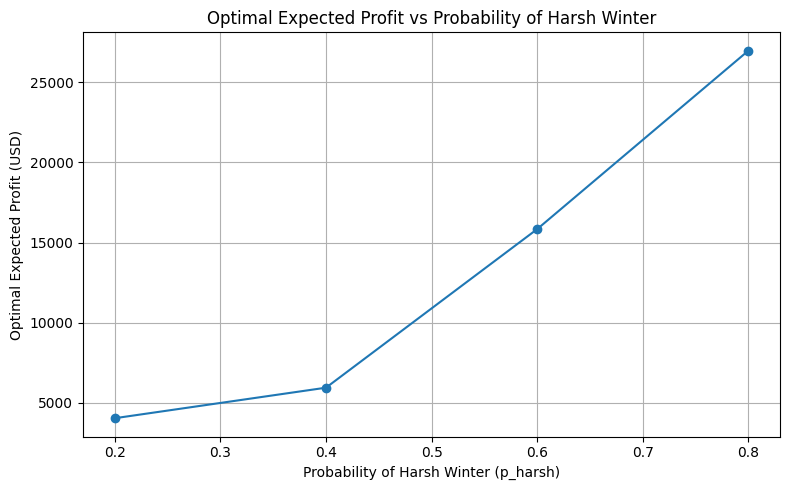


Plot saved to: c:\Users\brett\Documents\Business Analytics (2)\Business Analytics\Homework 15\optimal_expected_profit_vs_p_harsh.png
CSV files saved: optimal_results.csv, expected_profit_table_last_p.csv


In [5]:
# newsvendor_sensitivity.py
# Dynamic solver for the snow-shovel sensitivity analysis (discrete demand)
# Edit parameters below to match your problem instance.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ------------------ User-editable inputs (defaults from uploaded homework) ------------------
mild_demands = np.array([250, 300, 350])
mild_probs = np.array([0.5, 0.4, 0.1])

harsh_demands = np.array([1500, 2500, 3000])
harsh_probs = np.array([0.1, 0.3, 0.6])

# Economic parameters (change to match the textbook problem if different)
price = 25.0       # selling price per shovel (revenue when sold)
cost = 10.0        # purchase cost per shovel
salvage = 2.0      # salvage value per unsold shovel (set 0 if none)

# Vector of probabilities for a harsh winter (defaults requested: 0.2 to 0.8)
p_harsh_list = np.arange(0.2, 0.81, 0.2)

# Grid of candidate order quantities (tune q_step for resolution / speed)
q_min = 0
q_max = int(max(harsh_demands.max(), mild_demands.max()) * 1.05)
q_step = 10
Q_candidates = np.arange(q_min, q_max + 1, q_step)

# ------------------ Helper functions ------------------
def profit_for_single_outcome(Q, D, price, cost, salvage):
    revenue = price * min(Q, D)
    cost_total = cost * Q
    salvage_total = salvage * max(Q - D, 0)
    return revenue - cost_total + salvage_total

def expected_profit_given_scenario(Q, demands, demand_probs, price, cost, salvage):
    profits = [profit_for_single_outcome(Q, d, price, cost, salvage) for d in demands]
    return np.dot(profits, demand_probs)

def expected_profit_over_mixture(Q, p_harsh, mild_demands, mild_probs, harsh_demands, harsh_probs, price, cost, salvage):
    ep_mild = expected_profit_given_scenario(Q, mild_demands, mild_probs, price, cost, salvage)
    ep_harsh = expected_profit_given_scenario(Q, harsh_demands, harsh_probs, price, cost, salvage)
    return (1 - p_harsh) * ep_mild + p_harsh * ep_harsh

# ------------------ Main computation ------------------
results = []
for p_h in p_harsh_list:
    ep_values = [expected_profit_over_mixture(Q, p_h, mild_demands, mild_probs, harsh_demands, harsh_probs, price, cost, salvage) for Q in Q_candidates]
    ep_values = np.array(ep_values)
    best_index = np.argmax(ep_values)
    best_Q = int(Q_candidates[best_index])
    best_EP = float(ep_values[best_index])
    results.append({'p_harsh': float(p_h), 'optimal_Q': best_Q, 'optimal_expected_profit': best_EP})

results_df = pd.DataFrame(results)

# Optional: a full table of expected profits for the last p_harsh (for inspection)
last_p = p_harsh_list[-1]
ep_table = pd.DataFrame({
    'Q': Q_candidates,
    f'Expected_Profit_at_p_harsh_{last_p}': [expected_profit_over_mixture(Q, last_p, mild_demands, mild_probs, harsh_demands, harsh_probs, price, cost, salvage) for Q in Q_candidates]
})

# ------------------ Output ------------------
print("Parameters used (edit the code to change these):")
print(f"  price={price}, cost={cost}, salvage={salvage}")
print(f"  mild_demands={mild_demands.tolist()} with probs={mild_probs.tolist()}")
print(f"  harsh_demands={harsh_demands.tolist()} with probs={harsh_probs.tolist()}")
print(f"  Evaluating Q candidates from {q_min} to {q_max} step {q_step}")
print("\nOptimal results for each p_harsh:")
print(results_df.to_string(index=False))

# Plot
plt.figure(figsize=(8,5))
plt.plot(results_df['p_harsh'], results_df['optimal_expected_profit'], marker='o')  # no explicit color
plt.title('Optimal Expected Profit vs Probability of Harsh Winter')
plt.xlabel('Probability of Harsh Winter (p_harsh)')
plt.ylabel('Optimal Expected Profit (USD)')
plt.grid(True)
plt.tight_layout()

out_path = 'optimal_expected_profit_vs_p_harsh.png'
plt.savefig(out_path)
plt.show()

print(f"\nPlot saved to: {os.path.abspath(out_path)}")
# Optionally print or save results_df / ep_table to CSV:
results_df.to_csv('optimal_results.csv', index=False)
ep_table.to_csv('expected_profit_table_last_p.csv', index=False)
print("CSV files saved: optimal_results.csv, expected_profit_table_last_p.csv")


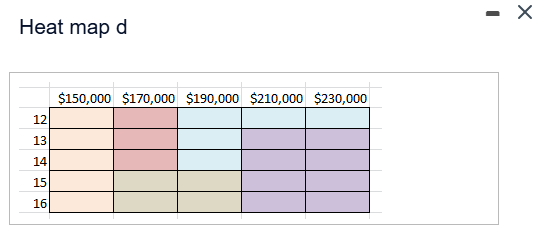